In [2]:
# Подключаем необходимые библиотеки
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torchsummary import summary
from torchvision.transforms.v2 import ToDtype, ToTensor
from torchviz import make_dot
from torchvision import models
from tqdm import tqdm
from torch.optim.lr_scheduler import ReduceLROnPlateau
from PIL import Image 

import matplotlib.pyplot as plt
import os
import pandas as pd

In [3]:
# Определяем гиперпараметры

batch_size = 32
num_epochs = 75
lr = 0.001
device = "cpu"

# Для transform

size = (64, 64)


if torch.cuda.is_available():
    device = torch.cuda

# cuda0 = torch.device('cuda')

print(device)
# print(cuda0)

cpu


In [4]:
# Путь к данным

data_dir = "./human_poses_data"
train_dir = os.path.join(data_dir, "img_train")
test_dir = os.path.join(data_dir, "img_test")
train_labels_path = os.path.join(data_dir, "train_answers.csv")

global_img_train_path = './human_poses_data'

# Чтение файла с метками
train_labels = pd.read_csv(train_labels_path)

print(data_dir)
train_labels['target_feature'].max()


./human_poses_data


18

In [5]:
train_labels

,img_id,target_feature
0,17363,2
1,8612,5
2,8244,0
3,9264,0
4,5382,6
...,...,...
12362,11503,4
12363,12201,6
12364,5489,3
12365,883,5


Добавим новые функции для сохранения чекпоинтов и модели.

[Saving and Loading Models](https://pytorch.org/tutorials/beginner/saving_loading_models.html)

In [6]:
# Добавляем новые функции для сохранения чекпоинтов

def save_checkpoint(model, optimizer, epoch, loss, filename="checkpoint.pth"):
    """Сохраняет чекпоинт модели и оптимизатора."""
    checkpoint = {
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "epoch": epoch,
        "loss": loss,
    }
    torch.save(checkpoint, filename)
    print(f"Checkpoint saved: {filename}, epoch {epoch}, loss {loss:.4f}")

def load_checkpoint(model, optimizer, filename="checkpoint.pth"):
    """Загружает чекпоинт модели и оптимизатора."""
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint["model_state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
    epoch = checkpoint["epoch"]
    loss = checkpoint["loss"]
    print(f"Checkpoint loaded: {filename}, epoch {epoch}, loss {loss:.4f}")
    return epoch, loss

In [7]:
# Произведем пребразования над данными для последующей их передачи в модель

# transform_train = transforms.Compose([
#     transforms.Resize(size=size), # Уменьшаем и приводим изображения к одному размеру
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# transform_test = transforms.Compose([
#     transforms.Resize(size=size), # Уменьшаем и приводим изображения к одному размеру
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
# ])

# transform = transforms.Compose([
#     transforms.Resize(size=size),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomRotation(15),
#     transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
#     transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
#     transforms.ToTensor(),
#     ToDtype(torch.float32, scale=True),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

train_transform = transforms.Compose([
    transforms.Resize(size=size), 
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.RandomApply([transforms.RandomAffine(degrees=2, translate=(0.1, 0.1))]),
    transforms.RandomApply([transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 2)), transforms.RandomGrayscale()]),
    transforms.RandomHorizontalFlip(),
    transforms.RandomChoice([transforms.RandomAdjustSharpness(1), transforms.RandAugment()]),
    transforms.ToTensor(),
    ToDtype(torch.float32, scale=True),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_transform_for_visualize = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_val_transform = transforms.Compose([
    transforms.Resize(size=size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [8]:
# # Пайплайн 1
# train_transform_1 = transforms.Compose([
#     transforms.Resize(size=size), 
#     transforms.RandomRotation(degrees=3),  # Немного больше вращения
#     transforms.ColorJitter(brightness=0.5, saturation=0.3),  # Контроль цвета и контраста
#     transforms.RandomHorizontalFlip(p=0.5),  # Случайный горизонтальный флип
#     transforms.RandomAdjustSharpness(sharpness_factor=0.8),  # Усиление резкости
#     transforms.ToTensor(),
#     ToDtype(torch.float32, scale=True),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Пайплайн 2
# train_transform_2 = transforms.Compose([
#     transforms.Resize(size=size),
#     transforms.RandomApply([transforms.RandomPerspective(distortion_scale=0.5, p=0.5)]),  # Перспективные искажения
#     transforms.ColorJitter(brightness=0.6, saturation=0.4),  # Более мягкие цветовые изменения
#     transforms.RandomApply([transforms.RandomAffine(degrees=10, shear=5)]),  # Легкий сдвиг
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.ToTensor(),
#     ToDtype(torch.float32, scale=True),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Пайплайн 3
# train_transform_3 = transforms.Compose([
#     transforms.Resize(size=size),
#     transforms.RandomAffine(degrees=2, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Легкие афинные преобразования
#     transforms.ColorJitter(hue=0.2, saturation=0.4),  # Мягкие изменения цвета
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomApply([transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 2))], p=0.5),  # Легкое размытие
#     transforms.RandomAdjustSharpness(sharpness_factor=1.1, p=0.3),  # Лёгкая корректировка резкости
#     transforms.ToTensor(),
#     ToDtype(torch.float32, scale=True),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Эти пайплайны похожи на первый пайплайн, эксперементируем с ним

# # train_transform = transforms.Compose([
# #     transforms.Resize(size=size), 
# #     transforms.RandomRotation(5),
# #     transforms.ColorJitter(brightness=1.5, saturation=0.2),
# #     transforms.RandomApply([transforms.RandomAffine(degrees=2, translate=(0.1, 0.1))]),
# #     transforms.RandomApply([transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 2)), transforms.RandomGrayscale()]),
# #     transforms.RandomHorizontalFlip(),
# #     transforms.RandomChoice([transforms.RandomAdjustSharpness(1), transforms.RandAugment()]),
# #     transforms.ToTensor(),
# #     ToDtype(torch.float32, scale=True),
# #     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# # ])

# # Пайплайн 4
# train_transform_4 = transforms.Compose([
#     transforms.Resize(size=size),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomRotation(degrees=3),
#     transforms.ColorJitter(brightness=0.8, contrast=0.4, saturation=0.5, hue=0.2),
#     transforms.RandomAffine(degrees=10, scale=(0.8, 1.2), shear=5),
#     transforms.RandomPerspective(distortion_scale=0.4, p=0.5),
#     transforms.RandomApply([transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 2))], p=0.3),
#     transforms.RandomGrayscale(p=0.1),
#     transforms.ToTensor(),
#     ToDtype(torch.float32, scale=True),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])


# # Пайплайн 5
# train_transform_5 = transforms.Compose([
#     transforms.Resize(size=size),
#     transforms.RandomAffine(degrees=2, scale=(0.8, 1.2), shear=5),
#     transforms.RandomApply([transforms.RandomRotation(30)], p=0.4),
#     transforms.RandomHorizontalFlip(p=0.5),
#     transforms.RandomApply([transforms.ColorJitter(brightness=0.7, contrast=0.7)], p=0.3),
#     transforms.RandomChoice([
#         transforms.GaussianBlur(kernel_size=1, sigma=(0.1, 1)),
#         transforms.RandomAdjustSharpness(sharpness_factor=2.0, p=0.5)
#     ]),
#     transforms.ToTensor(),
#     ToDtype(torch.float32, scale=True),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

# # Пайплайн 6
# train_transform_6 = transforms.Compose([
#     transforms.Resize(size=size),
#     transforms.RandomRotation(degrees=3),
#     transforms.RandomHorizontalFlip(),
#     transforms.RandomApply([
#         transforms.RandomAffine(degrees=4, translate=(0.2, 0.2)),
#         transforms.RandomPerspective(distortion_scale=0.3)
#     ], p=0.4),
#     transforms.RandomGrayscale(p=0.2),
#     transforms.ColorJitter(brightness=0.9, saturation=0.3, hue=0.2),
#     transforms.RandomChoice([
#         transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1)),
#         transforms.RandomAdjustSharpness(sharpness_factor=1.2, p=0.5)
#     ]),
#     transforms.ToTensor(),
#     ToDtype(torch.float32, scale=True),
#     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# ])

In [9]:
# Определим удобный класс Dataset для хранения данных

class HumanPoseDataset(Dataset):
    def __init__(self, img_dir, labels_df=None, transform=None):
        self.img_dir = img_dir
        self.labels_df = labels_df
        self.transform = transform
        self.img_files = os.listdir(self.img_dir)

    def __len__(self):
        return len(self.labels_df) if self.labels_df is not None else len(os.listdir(self.img_dir))
    
    def __getitem__(self, index):
        img_name = self.img_files[index]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        if self.labels_df is not None:
            img_id = int(os.path.splitext(img_name)[0])
            matching_rows = self.labels_df.loc[self.labels_df['img_id'] == img_id, "target_feature"]
            if not matching_rows.empty:
                label = matching_rows.values[0]
                return image, label
            
        else:
            return image, img_name


In [10]:
# Создаем DataLoader

train_dataset = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform)
train_dataset_view = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_for_visualize)
test_dataset = HumanPoseDataset(test_dir, transform=test_val_transform)

# # Проверяем разные аугментации
# train_dataset_pipeline1 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_1)
# train_dataset_pipeline2 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_2)
# train_dataset_pipeline3 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_3)
# train_dataset_pipeline4 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_4)
# train_dataset_pipeline5 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_5)
# train_dataset_pipeline6 = HumanPoseDataset(train_dir, labels_df=train_labels, transform=train_transform_6)

# Разделяем обучающий датасет на валидационную и обучающую выборки
val_size = int(0.2 * len(train_dataset))
train_size = len(train_dataset) - val_size
train_data, val_data = random_split(train_dataset, [train_size, val_size])

# # выборки из разных пайплайнов
# train_data1, val_data1 = random_split(train_dataset_pipeline1, [train_size, val_size])
# train_data2, val_data2 = random_split(train_dataset_pipeline2, [train_size, val_size])
# train_data3, val_data3 = random_split(train_dataset_pipeline3, [train_size, val_size])
# train_data4, val_data4 = random_split(train_dataset_pipeline4, [train_size, val_size])
# train_data5, val_data5 = random_split(train_dataset_pipeline5, [train_size, val_size])
# train_data6, val_data6 = random_split(train_dataset_pipeline6, [train_size, val_size])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# # Loader для 1 пайплайна
# train_loader1 = DataLoader(train_data1, batch_size=batch_size, shuffle=True)
# val_loader1 = DataLoader(val_data1, batch_size=batch_size, shuffle=False)

# # Loader для 2 пайплайна
# train_loader2 = DataLoader(train_data2, batch_size=batch_size, shuffle=True)
# val_loader2 = DataLoader(val_data2, batch_size=batch_size, shuffle=False)

# # Loader для 3 пайплайна
# train_loader3 = DataLoader(train_data3, batch_size=batch_size, shuffle=True)
# val_loader3 = DataLoader(val_data3, batch_size=batch_size, shuffle=False)

# # Loader для 4 пайплайна
# train_loader4 = DataLoader(train_data4, batch_size=batch_size, shuffle=True)
# val_loader4 = DataLoader(val_data4, batch_size=batch_size, shuffle=False)

# # Loader для 5 пайплайна
# train_loader5 = DataLoader(train_data5, batch_size=batch_size, shuffle=True)
# val_loader5 = DataLoader(val_data5, batch_size=batch_size, shuffle=False)

# # Loader для 6 пайплайна
# train_loader6 = DataLoader(train_data6, batch_size=batch_size, shuffle=True)
# val_loader6 = DataLoader(val_data6, batch_size=batch_size, shuffle=False)

Original pictures:



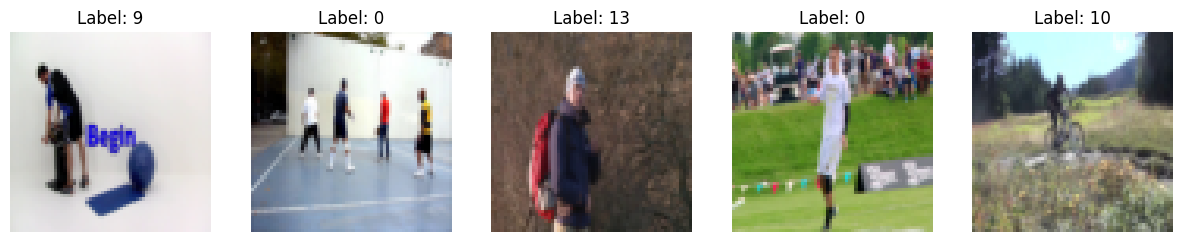

pictures after train_transform:



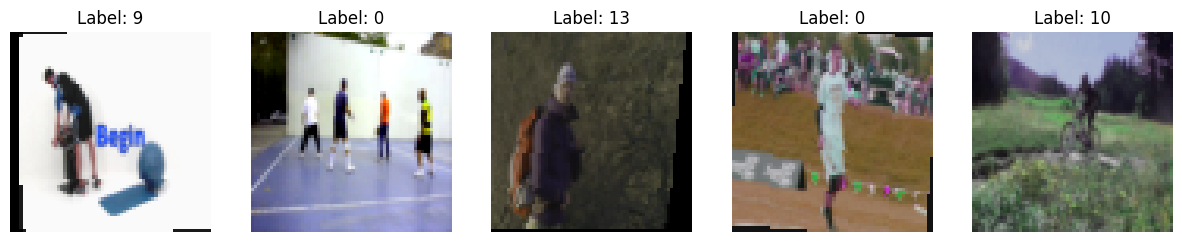

In [11]:
# Посмотрим на картинки в обучающей выборке

def show_images(dataset, num_images=5):
    """Функция для отображения нескольких изображений из датасета"""
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i in range(num_images):
        image, _label = dataset[i]  # Получаем изображение и метку
        # print(image)
        image = image.to(device).unsqueeze(0)
        # print(image)
        image = image.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5  # Меняем порядок осей для отображения и обратно нормализуем для отображения (если нормализовали)
        axes[i].imshow(image)
        axes[i].set_title(f"Label: {_label}")
        axes[i].axis("off")
    plt.show()

# Покажем несколько изображений из обучающего набора
print("Original pictures:\n")
show_images(train_dataset_view, num_images=5)
print("pictures after train_transform:\n")
show_images(train_dataset, num_images=5)

In [13]:
# # # class ImprovedVGG(nn.Module):
# # #     def __init__(self, num_classes=20):
# # #         super(ImprovedVGG, self).__init__()
# # #         self.features = nn.Sequential(
# # #             # Block 1
# # #             nn.Conv2d(3, 64, kernel_size=3, padding=1),  # Increased filters
# # #             nn.ReLU(inplace=True),
# # #             nn.BatchNorm2d(64),
# # #             nn.Conv2d(64, 64, kernel_size=3, padding=1),
# # #             nn.ReLU(inplace=True),
# # #             nn.BatchNorm2d(64),
# # #             nn.MaxPool2d(kernel_size=2, stride=2),

# # #             # Block 2
# # #             nn.Conv2d(64, 128, kernel_size=3, padding=1),  # Increased filters
# # #             nn.ReLU(inplace=True),
# # #             nn.BatchNorm2d(128),
# # #             nn.Conv2d(128, 128, kernel_size=3, padding=1),
# # #             nn.ReLU(inplace=True),
# # #             nn.BatchNorm2d(128),
# # #             nn.MaxPool2d(kernel_size=2, stride=2),

# # #             # Block 3
# # #             nn.Conv2d(128, 256, kernel_size=3, padding=1),  # Increased filters
# # #             nn.ReLU(inplace=True),
# # #             nn.BatchNorm2d(256),
# # #             nn.Conv2d(256, 256, kernel_size=3, padding=1),
# # #             nn.ReLU(inplace=True),
# # #             nn.BatchNorm2d(256),
# # #             nn.MaxPool2d(kernel_size=2, stride=2),

# # #             # Block 4
# # #             nn.Conv2d(256, 512, kernel_size=3, padding=1),  # Increased filters
# # #             nn.ReLU(inplace=True),
# # #             nn.BatchNorm2d(512),
# # #             nn.Conv2d(512, 512, kernel_size=3, padding=1),
# # #             nn.ReLU(inplace=True),
# # #             nn.BatchNorm2d(512),
# # #             nn.MaxPool2d(kernel_size=2, stride=2)
# # #         )

# # #         self.classifier = nn.Sequential(
# # #             nn.Linear(512 * 4 * 4, 1024),  # Adjusted for the output size after feature extraction
# # #             nn.ReLU(inplace=True),
# # #             nn.Dropout(p=0.5),
# # #             nn.Linear(1024, 512),
# # #             nn.ReLU(inplace=True),
# # #             nn.Dropout(p=0.5),
# # #             nn.Linear(512, num_classes)  # Output layer for the number of classes
# # #         )

# # #     def forward(self, x):
# # #         x = self.features(x)
# # #         x = x.view(x.size(0), -1)  # Flatten the tensor
# # #         x = self.classifier(x)
# # #         return x

# # # я с этим по экспериментировал и 4 слоя это оптималка на эпоху уходило в районе 20+ минут результаты улучшились на первых 3х эпохах по сравнению с 3 т.к. при 5 на одну эпоху уходило в районе 50 минут (50 минут это с условием отображения лосса и т.д.) 

# # class ImprovedVGG(nn.Module):
# #     def __init__(self, num_classes=19):
# #         super(ImprovedVGG, self).__init__()
# #         self.features = nn.Sequential(
# #             # Block 1
# #             nn.Conv2d(3, 32, kernel_size=3, padding=1),
# #             nn.ReLU(inplace=True),
# #             nn.BatchNorm2d(32),
# #             nn.Conv2d(32, 32, kernel_size=3, padding=1),
# #             nn.ReLU(inplace=True),
# #             nn.BatchNorm2d(32),
# #             nn.MaxPool2d(kernel_size=2, stride=2),

# #             # Block 2
# #             nn.Conv2d(32, 64, kernel_size=3, padding=1),
# #             nn.ReLU(inplace=True),
# #             nn.BatchNorm2d(64),
# #             nn.Conv2d(64, 64, kernel_size=3, padding=1),
# #             nn.ReLU(inplace=True),
# #             nn.BatchNorm2d(64),
# #             nn.MaxPool2d(kernel_size=2, stride=2),

# #             # Block 3
# #             nn.Conv2d(64, 128, kernel_size=3, padding=1),
# #             nn.ReLU(inplace=True),
# #             nn.BatchNorm2d(128),
# #             nn.Conv2d(128, 128, kernel_size=3, padding=1),
# #             nn.ReLU(inplace=True),
# #             nn.BatchNorm2d(128),
# #             nn.MaxPool2d(kernel_size=2, stride=2),

# #             # Block 4
# #             nn.Conv2d(128, 256, kernel_size=3, padding=1),
# #             nn.ReLU(inplace=True),
# #             nn.BatchNorm2d(256),
# #             nn.Conv2d(256, 256, kernel_size=3, padding=1),
# #             nn.ReLU(inplace=True),
# #             nn.BatchNorm2d(256),
# #             nn.MaxPool2d(kernel_size=2, stride=2)
# #         )

# #         # Измените размер в соответствии с выходом после сверток
# #         self.classifier = nn.Sequential(
# #             nn.Linear(256 * 4 * 4, 512),  # Убедитесь, что размер соответствует выходу
# #             nn.ReLU(inplace=True),
# #             nn.Dropout(p=0.5),
# #             nn.Linear(512, 256),
# #             nn.ReLU(inplace=True),
# #             nn.Dropout(p=0.5),
# #             nn.Linear(256, num_classes)  # Выходной слой для количества классов
# #         )

# #     def forward(self, x):
# #         x = self.features(x)
# #         x = x.view(x.size(0), -1)  # Преобразование тензора в одномерный
# #         x = self.classifier(x)
# #         return x

# import torch
# import torch.nn as nn

# class ImprovedVGG(nn.Module):
#     def __init__(self, num_classes=20):
#         super(ImprovedVGG, self).__init__()
#         self.features = nn.Sequential(
#             # Block 1
#             nn.Conv2d(3, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(64, 64, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Block 2
#             nn.Conv2d(64, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(128),
#             nn.Conv2d(128, 128, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(128),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Block 3
#             nn.Conv2d(128, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(256),
#             nn.Conv2d(256, 256, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(256),
#             nn.MaxPool2d(kernel_size=2, stride=2),

#             # Block 4
#             nn.Conv2d(256, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(512),
#             nn.Conv2d(512, 512, kernel_size=3, padding=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(512),
#             nn.MaxPool2d(kernel_size=2, stride=2)
#         )

#         # Обновление размеров в линейном слое
#         self.classifier = nn.Sequential(
#             nn.Linear(512 * 8 * 8, 1024),  # 512 * 8 * 8 вместо 512 * 4 * 4
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(1024, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(512, num_classes)
#         )

#     def forward(self, x):
#         x = self.features(x)
#         x = x.view(x.size(0), -1)  # Flatten the tensor
#         x = self.classifier(x)
#         return x

class ImprovedVGG(nn.Module):
    def __init__(self, num_classes=20):
        super(ImprovedVGG, self).__init__()
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 4
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 5
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Глобальное усреднение перед полносвязными слоями
        self.global_pool = nn.AdaptiveAvgPool2d((1, 1))

        self.classifier = nn.Sequential(
            nn.Linear(512, 1024),  # Убедитесь, что размер соответствует выходу
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=0.5),
            nn.Linear(512, num_classes)  # Выходной слой для количества классов
        )

    def forward(self, x):
        x = self.features(x)
        x = self.global_pool(x)  # Применение глобального усреднения
        x = x.view(x.size(0), -1)  # Преобразование тензора в одномерный
        x = self.classifier(x)
        return x

In [14]:
from torchsummary import summary

# Выведем summary модели
num_classes = len(range(train_labels["target_feature"].min(), train_labels["target_feature"].max()))
print("Кол-во классов:", num_classes)

vgg = ImprovedVGG().to(device)
print(vgg)

Кол-во классов: 18
ImprovedVGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False

In [15]:
summary(vgg, (3, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,792
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
            Conv2d-4           [-1, 64, 64, 64]          36,928
       BatchNorm2d-5           [-1, 64, 64, 64]             128
              ReLU-6           [-1, 64, 64, 64]               0
         MaxPool2d-7           [-1, 64, 32, 32]               0
            Conv2d-8          [-1, 128, 32, 32]          73,856
       BatchNorm2d-9          [-1, 128, 32, 32]             256
             ReLU-10          [-1, 128, 32, 32]               0
           Conv2d-11          [-1, 128, 32, 32]         147,584
      BatchNorm2d-12          [-1, 128, 32, 32]             256
             ReLU-13          [-1, 128, 32, 32]               0
        MaxPool2d-14          [-1, 128,

In [16]:
# Функция для визуализации графика ошибок и метрик
def visualize_model_results(train_losses, val_losses, val_metrics, epochs):
    val_acc = [m[0] for m in val_metrics] 
    val_f1 = [m[3] for m in val_metrics]

    plt.figure(figsize=(12, 6)) 
    plt.subplot(1, 2, 1) 
    plt.plot(range(0, epochs), train_losses, label="Train Loss")
    plt.plot(range(0, epochs), val_losses, label="Val Loss")
    plt.xlabel("Epoch") 
    plt.ylabel("Loss") 
    plt.title("Training Loss") 
    plt.legend() 

    plt.subplot(1, 2, 2) 
    plt.plot(val_acc, label="Validation Accuracy") 
    plt.plot(val_f1, label="Validation F1-Score") 
    plt.xlabel("Epoch") 
    plt.ylabel("Value") 
    plt.title("Validation Metrics") 
    plt.legend() 

    plt.tight_layout() 
    plt.show()

In [17]:
# # Early stopping
# early_stopping = EarlyStopping(patience=3, delta=0.01)

# Функция обучения и оценки 

def train_and_evaluate(model, criterion, optimizer, train_loader, val_loader, num_epochs, 
                       lr=1e-3, checkpoint_dir='./checkpoints', checkpoint_path=None):
    train_losses, val_losses = [], []
    val_metrics = []

    os.makedirs(checkpoint_dir, exist_ok=True)
    start_epoch = 0

    scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5, verbose=True)

    # Загрузка чекпоинта, если он указан
    if checkpoint_path is not None:
        checkpoint = torch.load(checkpoint_path)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Resuming training from epoch {start_epoch}")

    try:
        for epoch in range(start_epoch, num_epochs):
            # Обучение
            model.train()
            train_loss = 0
            for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Training]'):
                images = images.to(device)
                # images = images.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(images)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()

            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Оценка
            model.eval()
            val_loss = 0
            all_preds = []
            all_labels = []
            with torch.no_grad():
                for images, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Validation]"):
                    images = images.to(device)
                    # images = images.cpu().squeeze().permute(1, 2, 0) * 0.5 + 0.5
                    labels = labels.to(device)
                    outputs = model(images)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item()

                    preds = torch.argmax(outputs, dim=1)
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())

            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            acc = accuracy_score(all_labels, all_preds)
            prec = precision_score(all_labels, all_preds, average="weighted")
            rec = recall_score(all_labels, all_preds, average="weighted")
            f1 = f1_score(all_labels, all_preds, average="weighted")
            val_metrics.append((acc, prec, rec, f1))

            print(f"Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, "
                f"Val Acc: {acc:.4f}, Val Prec: {prec:.4f}, Val Recall: {rec:.4f}, Val F1: {f1:.4f}")
            
            scheduler.step(val_loss)

            # Сохранение чекпоинтов
            if (epoch + 1) % 5 == 0:
                checkpoint_path = os.path.join(checkpoint_dir, f"model_epoch{epoch + 1}_acc{acc:.4f}.pth")
                torch.save({'epoch': epoch + 1,
                            'model_state_dict': model.state_dict(),
                            'optimizer_state_dict': optimizer.state_dict(),
                            'val_loss': val_loss}, checkpoint_path)
    except KeyboardInterrupt as key_interrupt_e:
        print(f"Training was interrupted. Residual visualization of passed epochs: {key_interrupt_e}")
        visualize_model_results(train_losses, val_losses, val_metrics, epochs=epoch)
            
        # # Добавляем early stopping
        # early_stopping(val_loss=val_loss, model=model)
        # if early_stopping.early_stop:
        #     print("Early stopping trigered. Training stopped.")
        #     print(f"Model saved at {epoch + 1} epoch.")
        #     torch.save({'epoch': epoch + 1,
        #                 'model_state_dict': model.state_dict(),
        #                 'optimizer_state_dict': optimizer.state_dict(),
        #                 'val_loss': val_loss}, checkpoint_path)
            
        

    return train_losses, val_losses, val_metrics

In [18]:
# Определяем критерий и оптимизатор
criterion = nn.CrossEntropyLoss() 
optimizer = optim.Adam(vgg.parameters(), lr=lr) 

In [19]:
# Функция для предсказания и сохранения результатов
def predict_and_save(model, test_loader, output_file):
    model.eval()
    predictions = []

    with torch.no_grad():
        for images, ids in tqdm(test_loader):  # img_name_batch нам не нужен для индексации
            images = images.to(device)
            # ids = ids.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1).cpu().numpy()
            
            for img_id, pred in zip(ids, preds):
                predictions.append((img_id, pred))

    # Создаем DataFrame с индексами и предсказаниями
    results_df = pd.DataFrame(predictions, columns=['id', 'target_feature'])
    results_df['id'] = results_df['id'].str.replace(".jpg", "")

    # Сохраняем файл в формате CSV
    results_df.to_csv(output_file, index=False)
    print(f"Предсказания сохранены в файл {output_file}")

c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch 1/75 [Validation]: 100%|██████████| 78/78 [00:59<00:00,  1.31it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 1/75, Train Loss: 2.6572, Val Loss: 2.5134, Val Acc: 0.2277, Val Prec: 0.1161, Val Recall: 0.2277, Val F1: 0.1305


Epoch 2/75 [Validation]: 100%|██████████| 78/78 [00:40<00:00,  1.91it/s]
c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Epoch 2/75, Train Loss: 2.5364, Val Loss: 2.5033, Val Acc: 0.2386, Val Prec: 0.0992, Val Recall: 0.2386, Val F1: 0.1349


Epoch 3/75 [Training]:   1%|          | 3/310 [00:01<02:49,  1.81it/s]


Training was interrupted. Residual visualization of passed epochs: 


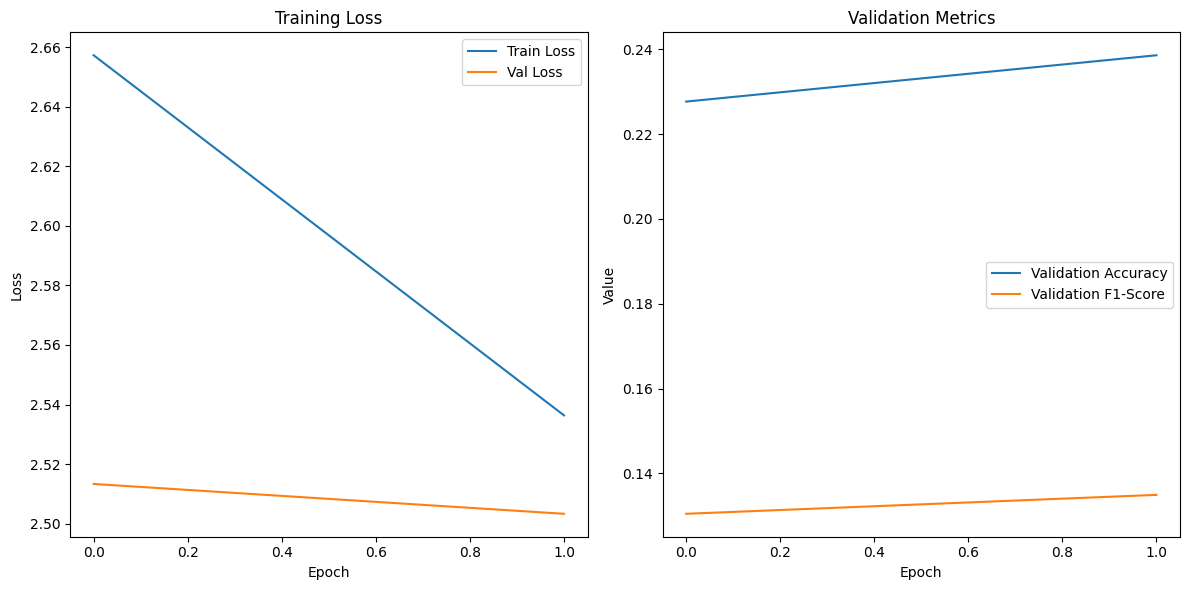

In [167]:
# Запуск обучения и валидации. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(
    vgg, criterion, optimizer, train_loader, val_loader, num_epochs=75, lr=lr) 

In [23]:
check = torch.load('checkpoint_epoch_85.pth', map_location=torch.device('cpu'))

In [24]:
# Запуск обучения и валидации. Пример, чтобы посмотреть на изменение
train_losses, val_losses, val_metrics = train_and_evaluate(
    vgg, criterion, optimizer, train_loader, val_loader, num_epochs=75, lr=lr, checkpoint_path=check) 

c:\Users\boris\anaconda3\envs\conda_env_24_25\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


AttributeError: 'dict' object has no attribute 'seek'. You can only torch.load from a file that is seekable. Please pre-load the data into a buffer like io.BytesIO and try to load from it instead.